In [42]:
from dataset import read_image
import pandas as pd
import numpy as np
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

import matplotlib.pyplot as plt
import im

In [43]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target
    
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

In [44]:
class CNNModel(nn.Module):
    def __init__(self, input_channels):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 1)  # Regression output
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [45]:
train_dataset, test_dataset = read_image(gray_img=False)
train_images = list()
train_targets = list()
test_images = list()
test_targets = list()
for data in train_dataset:
    train_images.append(data[0])
    train_targets.append(data[1])

for data in test_dataset:
    test_images.append(data[0])
    test_targets.append(data[1])

train_images = np.array(train_images)
train_targets = np.array(train_targets)
test_images = np.array(test_images)
test_targets = np.array(test_targets)

~1500
1500~1800
1800~1970
1970~


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_channels = 3
model = CNNModel(input_channels=input_channels).to(device)
model.load_state_dict(torch.load('../models/cnn_regression_model.pth'))
print(model.conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [47]:
def predict(image_path, model, transform):
    # Read and preprocess the image
    image = cv2.imread('../data/1800~1970/{}'.format(image_path))
    if input_channels == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=2)  # Add channel dimension
    if image is None:
        print(f"Error reading image: {image_path}")
        return

    image = cv2.resize(image, (256, 256))
    image = transform(image).unsqueeze(0).to(device)
    
    # Predict the year
    with torch.no_grad():
        output = model(image)
    
    return output.item()

In [48]:
# Example prediction
"""
image_path = '5.jpg'
predicted_year = predict(image_path, model, transform)
print(f"Predicted Year: {predicted_year}")
print(train_targets[4])
print()
"""

i = 0
diff = list()
bads = []
titles = []
heatmaps = []

predicted_years = np.array(test_dataset)[:,1]
mispredicted_years = []

cam = GradCAM(model=model, target_layers=[model.conv2])

for data in test_dataset:
    i += 1
    img = cv2.cvtColor(data[0].copy(),cv2.COLOR_BGR2RGB)
    image = data[0]
    year = data[1]
    image = transform(image).unsqueeze(0).to(device).float()
    with torch.no_grad():
        output = round(model(image).item())
    
    print(i, "image")
    print("Predicted Year :", output)
    print("Actual Year :", year)
    print("Difference between predict and true :", year - output)
    if abs(year-output)>1000:
        bads.append(img)
        titles.append('Predict:'+str(output)+'  /  True:'+str(year))
        heatmaps.append(cam(input_tensor=image, targets=None)[0,:])
        mispredicted_years.append(year)
    diff.append(abs((year - output).item()))
    print()

print('Avg :', sum(diff) / i)
    

1 image
Predicted Year : 396
Actual Year : -1850
Difference between predict and true : -2246

2 image
Predicted Year : 1186
Actual Year : 1837
Difference between predict and true : 651

3 image
Predicted Year : 1345
Actual Year : 1947
Difference between predict and true : 602

4 image
Predicted Year : 1700
Actual Year : -390
Difference between predict and true : -2090

5 image
Predicted Year : 1685
Actual Year : 50
Difference between predict and true : -1635

6 image
Predicted Year : 1018
Actual Year : 1767
Difference between predict and true : 749

7 image
Predicted Year : 654
Actual Year : 50
Difference between predict and true : -604

8 image
Predicted Year : 1219
Actual Year : 1909
Difference between predict and true : 690

9 image
Predicted Year : 1252
Actual Year : 1904
Difference between predict and true : 652

10 image
Predicted Year : 1916
Actual Year : 1949
Difference between predict and true : 33

11 image
Predicted Year : 919
Actual Year : 1385
Difference between predict an

C:\Users\Rain sytwu\AppData\Local\Temp\ipykernel_11004\3272240891.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted_years = np.array(test_dataset)[:,1]


17 image
Predicted Year : 506
Actual Year : 216
Difference between predict and true : -290

18 image
Predicted Year : 1852
Actual Year : 1914
Difference between predict and true : 62

19 image
Predicted Year : 1133
Actual Year : 2010
Difference between predict and true : 877

20 image
Predicted Year : 1836
Actual Year : 1873
Difference between predict and true : 37

21 image
Predicted Year : 1482
Actual Year : -650
Difference between predict and true : -2132

22 image
Predicted Year : 1501
Actual Year : 1954
Difference between predict and true : 453

23 image
Predicted Year : 1691
Actual Year : 1697
Difference between predict and true : 6

24 image
Predicted Year : 1906
Actual Year : 1900
Difference between predict and true : -6

25 image
Predicted Year : 1667
Actual Year : 1838
Difference between predict and true : 171

26 image
Predicted Year : 635
Actual Year : 68
Difference between predict and true : -567

27 image
Predicted Year : 1663
Actual Year : 1571
Difference between predict

In [ ]:
for i,(bad_img,title,heatmap) in enumerate(zip(bads,titles,heatmaps)):
    plt.axis('off')
    plt.title(title)
    plt.imshow(bad_img)
    plt.savefig(f"../result/bad{i}.png")
    plt.show()
    
    cam_img = show_cam_on_image(np.float32(bad_img)/255, heatmap, use_rgb=False)
    plt.axis('off')
    plt.title(title)
    plt.imshow(cam_img,cmap='jet')
    plt.savefig(f"../result/bad{i}_heatmap.png")
    plt.show()

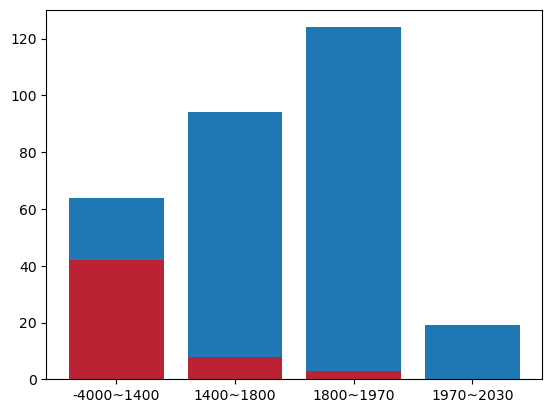

In [51]:
pys = np.array(predicted_years)
mpys = np.array(mispredicted_years)

bins = [-4000, 1400, 1800, 1970, 2024]
labels = ['-4000~1400', '1400~1800', '1800~1970', '1970~2024']

values1, _ = np.histogram(pys, bins=bins)
values2, _ = np.histogram(mpys, bins=bins)

plt.bar(labels, values1, label='List 1')
plt.bar(labels, values2, color='red', alpha=0.7, label='List 2')

plt.show()


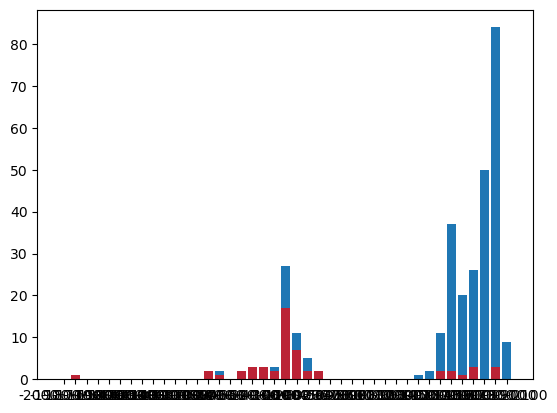

In [56]:
bins2 = range(-2000,2124,100)
labels2 = [str(i)+'~'+str(i+100) for i in bins2[:-1]]

values3, _ = np.histogram(pys, bins=bins2)
values4, _ = np.histogram(mpys, bins=bins2)

plt.bar(labels2, values3, label='List 1')
plt.bar(labels2, values4, color='red', alpha=0.7, label='List 2')

plt.xticks(rotation='vertical')
plt.show()